<a href="https://colab.research.google.com/github/fcjjx/MSE485-Final-project/blob/main/mse485projecyfinalversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install condacolab

In [2]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh")

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/25.3.1-0/Miniforge3-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:21
🔁 Restarting kernel...


# Install necessary tools!

In [1]:
# install dependencies
import subprocess
import sys
subprocess.run("pip install numpy==2.0.0", shell=True)
import numpy as np
print(np.__version__)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install openmm pdbfixer -y", shell=True)
subprocess.run("pip install rdkit==2025.3.1", shell=True)
subprocess.run("pip install prolif==1.1.0", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed -y", shell=True)
subprocess.run("mamba install -c conda-forge mdtraj -y", shell=True)
subprocess.run("pip install MDAnalysis==2.8.0", shell=True)

#load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

2.0.0


# Mounted Google drive
# Input pdb files from google drive! (both protein and ligand)

In [2]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# View input files and ligand strucutre from imported pdb
Choose the correct file name for both and use right Drive Path

In [3]:
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdForceFieldHelpers
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from pdbfixer import PDBFixer
from openbabel import pybel
import os
import subprocess
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


Protein_PDB_file_name = 'protein.pdb' #@param {type:"string"}
remove_waters = "yes" #@param ["yes", "no" ]
if remove_waters == "yes":
  no_waters = "nowat"
else:
  no_waters = ''

Ligand_PDB_file_name = 'ligand.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "Yes" #@param ["Yes", "No"]
Charge = 0 #@param {type:"slider", min:-10, max:10, step:1}


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = '/content/drive/MyDrive/mse485wt' #@param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(Protein_PDB_file_name))
prepareforleap = os.path.join(workDir, "prepareforleap.in")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")


def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def remove_lines(filename):
    with open(filename, 'r') as file:
        ter_count = 0
        for line in file:
            if line.startswith('TER'):
                ter_count += 1
                if ter_count >= 1:
                    yield line
                    for i in range(3):
                        line = next(file, None)
                        if line is not None and line.startswith('ATOM') and line.split()[2] in ['P', 'OP1', 'OP2']:
                            continue
                        else:
                            yield line
                else:
                    yield line
            else:
                yield line

# if Add_ligand_hydrogens == "Yes":
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   mol = Chem.MolFromMolFile('temp.mol', removeHs=True)
#   hmol = Chem.AddHs(mol)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)
# else:
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)



#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))

  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  # with open(ligand_pdb2, 'w') as h:
  #   with open("temp2.pdb") as f:
  #     for line in f:
  #       data = line.split()
  #       if data[0] == "ATOM":
  #         if data[1] not in H_id:
  #           print(line, file=h)
  #       elif data[0] == "CONECT":
  #           if data[1] not in atom_id:
  #             print(line, file=h)
  #       else:
  #         print(line, file=h)

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip():  # Check if line is not empty or just whitespace
                data = line.split()
                if len(data) > 0 and data[0] not in ["TER", "ENDMDL"]:  # Exclude lines starting with TER or ENDMDL
                    if data[0] == "ATOM":
                        if data[1] not in H_id:
                            print(line, end='', file=h)  # Avoid adding extra newline
                    elif data[0] == "CONECT":
                        if data[1] not in atom_id:
                            print(line, end='', file=h)
                    else:
                        print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

else:
  ppdb = PandasPdb().read_pdb(ligand_pdb)
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)
  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip() and not line.startswith(("TER", "ENDMDL")):
                print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)


#Fix protein
f = open(prepareforleap, "w")
f.write("""parm """ + str(initial_pdb) + "\n"
"""loadcrd """ + str(initial_pdb) + """ name edited""" + "\n"
"""prepareforleap crdset edited name from-prepareforleap \ """ + "\n"
"""pdbout """ + str(starting_end) + " " + str(no_waters) + """ noh""" + "\n"
"""go """)
f.close()

prepareforleap_command = "cpptraj -i " + str(prepareforleap)
original_stdout = sys.stdout # Save a reference to the original standard output
with open('prepareforleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prepareforleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 prepareforleap.sh"], shell=True)
subprocess.run(["./prepareforleap.sh"], shell=True,)


pdb4amber_cmd = "pdb4amber -i " + str(starting) + " -o " + str(starting_end) + " -a"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)

# with open(starting_end, 'w') as out_file:
#     for line in remove_lines(starting2):
#         out_file.write(line)

protein_check = os.path.exists(starting_end)
ligand_check = os.path.exists(ligand_pdb2)

if protein_check == True and ligand_check == True:
  print("Successfully generated protein and ligand files! :-)")
else:
  print("ERROR: Check your inputs! ")

<>:227: SyntaxWarning: invalid escape sequence '\ '
<>:227: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-526745074.py:227: SyntaxWarning: invalid escape sequence '\ '
  """prepareforleap crdset edited name from-prepareforleap \ """ + "\n"


Charge = 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Successfully generated protein and ligand files! :-)


# Generate the protein-ligand Complex!

In [4]:
from rdkit import Chem
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2"]

# Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
# if chiralCentres == []:
#   isomer_end = isomer1
# else:
#   isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = charge

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
#   Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))

#   in_prmtop = top
#   in_crd = crd
#   orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
#   pieces = orig_structure.split()
#   for piece in pieces:
#       print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

#   from openmm.app import PDBFile
#   from openff.toolkit.topology import Molecule, Topology
#   from openff.toolkit.tests.utils import get_data_file_path

#   # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
#   # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

#   ligand_off_molecule = Molecule.from_smiles(isomer_end)
#   ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
#   ligand_off_topology = Topology.from_openmm(
#       ligand_pdbfile.topology,
#       unique_molecules=[ligand_off_molecule],)

#   force_field = ForceField("openff_unconstrained-2.0.0.offxml")

#   ligand_system = force_field.create_openmm_system(ligand_off_topology)
#   new_ligand_structure = parmed.openmm.load_topology(
#       ligand_off_topology.to_openmm(),
#       ligand_system,
#       xyz=pieces[1][0].positions,)

#   new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
#   new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

#   # Check how many atoms and which order elements are in the new ligand
#   n_atoms_new = len(new_ligand_structure.atoms)
#   elements_new = [atom.element for atom in new_ligand_structure.atoms]

#   # Check how many atoms and which order elements are in the old ligand
#   old_ligand_structure, n_copies = pieces[1]
#   n_atoms_old = len(old_ligand_structure.atoms)
#   elements_old = [atom.element for atom in old_ligand_structure.atoms]

#   print(
#       f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
#       f"in the new ligand structure")

#   # Print out error message if number of atoms doesn't match
#   if n_atoms_new != n_atoms_old:
#       print(
#           "Error: Number of atoms in input ligand doesn't match number extracted "
#           "from prmtop file.")

#   if elements_new != elements_old:
#       print(
#           "Error: Elements in input ligand don't match elements in the ligand "
#           "from the prmtop file.")
#       print(f"Old elements: {elements_old}")
#       print(f"New elements: {elements_new}")

#   # Create a new, empty system
#   complex_structure = parmed.Structure()

#   # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
#   complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

#   # Add the ligand
#   complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

#   # Add ions and Waters
#   ppdb = PandasPdb().read_pdb(pdb)
#   Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
#   Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
#   K = [ppdb.df['ATOM']['atom_name'] == 'K+']
#   Cl = np.array(Cl)
#   Na = np.array(Na)
#   K = np.array(K)

#   if True in Cl and True in Na:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     just_ion2_structure = parmed.Structure()
#     just_ion2_structure += pieces[3][0]
#     just_ion2_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[4][0]
#     just_water_structure *= len(pieces[4][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Cl and True in K:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     just_ion2_structure = parmed.Structure()
#     just_ion2_structure += pieces[3][0]
#     just_ion2_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[4][0]
#     just_water_structure *= len(pieces[4][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Cl:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Na:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in K:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   else:
#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[2][0]
#     just_water_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

#   # Copy over the original coordinates and box vectors
#   complex_structure.coordinates = orig_structure.coordinates
#   complex_structure.box_vectors = orig_structure.box_vectors

#   # Export the Structure to AMBER files
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   complex_structure.save(top, overwrite=True)
#   complex_structure.save(crd, overwrite=True)
#   top_openff = os.path.exists(top)
#   crd_openff = os.path.exists(crd)
#   if top_openff == True and crd_openff == True:
#     print("Successfully generated topology! :-)")
#   else:
#     print("ERROR: Check your inputs! ")

pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your inputs! ")
!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


# MD equilibriation protocol

In [5]:
Jobname = 'prot_lig_equil' #@param {type:"string"}

# Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   pdb = os.path.join(workDir, "SYS.pdb")
# else:
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "10000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds):
Time = "2.5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol):
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds):

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds):

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


In [6]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**


import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')

		for atom1 in restraint_array:
			atom1 = int(atom1)

			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole/nanometer, maxIterations=int(Minimization_steps))

print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

<>:58: SyntaxWarning: invalid escape sequence '\#'
<>:58: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipython-input-545437963.py:58: SyntaxWarning: invalid escape sequence '\#'
  backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"



> Simulation details:

	Job name = /content/drive/MyDrive/mse485wt/prot_lig_equil
	Coordinate file = /content/drive/MyDrive/mse485wt/SYS_gaff2.crd
	PDB file = /content/drive/MyDrive/mse485wt/SYS.pdb
	Topology file = /content/drive/MyDrive/mse485wt/SYS_gaff2.prmtop

	Simulation_time = 2500.0 ps
	Integration timestep = 2 fs
	Total number of steps = 1250000

	Save coordinates each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 700kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 10000 steps
	-> Potential Energy = -556696.6658057882 kJ/mol
	- Setting initial velocities...

> Simulating 1250000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
0.4%		5000		0		--
0.8%		10000		287		12:25
1.2%		15000		300		11:50
1.6%		20000		304		11:39
2.0%		25000		305		11:33
2.4%	

# Production MD simulation Parameters

In [17]:
Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
State_file = 'prot_lig_equil.rst' #@param {type:"string"}
Ligand_Force_field = "GAFF2"
#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@param {type:"string"}

# Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   pdb = os.path.join(workDir, "SYS.pdb")

# else:
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds):
Stride_Time = "5" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "10" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds):
Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

In [18]:
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

<>:56: SyntaxWarning: invalid escape sequence '\#'
<>:56: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipython-input-2749563502.py:56: SyntaxWarning: invalid escape sequence '\#'
  backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"



> Simulation details:

	Job name = /content/drive/MyDrive/mse485wt/prot_lig_prod
	Coordinate file = /content/drive/MyDrive/mse485wt/SYS_gaff2.crd
	PDB file = /content/drive/MyDrive/mse485wt/prot_lig_equil.pdb
	Topology file = /content/drive/MyDrive/mse485wt/SYS_gaff2.prmtop

	Simulation_time = 50000.0 ps
	Integration timestep = 2 fs
	Total number of steps = 25000000
	Number of strides = 10 (5000.0 ps in each stride)

	Save coordinates each 10 ps
	Save checkpoint each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting barostat...
	- Setting integrator...


>>> Simulating Stride #1 <<<
> Stride #1 finished (/content/drive/MyDrive/mse485wt/prot_lig_prod_1.rst present). Moving to next stride... <


>>> Simulating Stride #2 <<<
> Stride #2 finished (/content/drive/MyDrive/mse485wt/prot_lig_prod_2.rst present). Moving to next stride... <


>>

In [19]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/drive/MyDrive/mse485wt' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'prot_lig_equil.pdb' #@param {type:"string"}
Jobname = "prot_lig_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "10" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "5" #@param {type:"string"}
trajectory_saved_frequency = "10" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(Skip)


nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]

if Remove_waters == "yes":
  #Save topology without waters
  gaff_top = pt.load_topology(os.path.join(workDir, "SYS_gaff2.prmtop"))
  gaff_nw = gaff_top['!:WAT']
  gaff_nw.save(os.path.join(workDir, "SYS_gaff2_nw.prmtop"))
  # Save trajectory without waters
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  t0 = trajlist.strip(':WAT')
  traj_image = t0.iterframe(autoimage=True, rmsfit=0)
  traj_nw = pt.write_traj(nw_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2_nw.prmtop")
else:
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
  traj = pt.write_traj(whole_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(whole_dcd)
  traj = whole_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2.prmtop")

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 5000 frames: 
Size: 0.302866 (GB)
<Topology: 2710 atoms, 238 residues, 76 mols, PBC with box type = orthorhombic>
           
Trajectory concatenated successfully! :-)


# Ligplot Generation

In [20]:
Output_name = 'Interaction' #@param {type:"string"}

#@markdown The frequency with which an interaction is seen will control the width of the corresponding edge. You can hide the least frequent interactions by using a threshold, i.e. threshold=0.3 will hide interactions that occur in less than 30% of frames.
Threshold = 0.3 #@param {type:"slider", min:0, max:1.0, step:0.1}

import MDAnalysis as mda
import prolif as plf
import numpy as np
import os
from prolif.plotting.network import LigNetwork

# load topology
u = mda.Universe(pdb_ref, traj)
lig = u.select_atoms("resname LIG")
prot = u.select_atoms("protein")

# create RDKit-like molecules for visualisation
lmol = plf.Molecule.from_mda(lig)
pmol = plf.Molecule.from_mda(prot)

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

fp = plf.Fingerprint()
fp.run(u.trajectory[::int(stride_animation)], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(df, lmol,
                          # replace with `kind="frame", frame=0` for the other depiction
                          kind="aggregate", threshold=float(Threshold),
                          rotation=270)
net.save(os.path.join(workDir, Output_name + ".html"))
net.display()

/usr/local/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/site-packages/prolif/utils.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=["ligand", "protein", "interaction"]).agg(tuple)
/usr/local/lib/python3.12/site-packages/prolif/plotting/network.py:293: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ifp.applymap(lambda x: x[0]).astype(object), prefix_sep=", "


# MM-PBSA / MM-GBSA method to calculate the binding free energy

In [21]:
igb = "2" #@param ["1", "2", "5", "7", "8"]

import os
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if igb == "1":
  mbondi = 'mbondi'
elif igb == "2" or igb == "5":
  mbondi = 'mbondi2'
elif igb == "7":
  mbondi = 'bondi'
elif igb == "8":
  mbondi = 'mbondi3'
else:
  pass

Salt_concentration = '0.15' #@param {type:"string"}
fold_MMPBSA = "MMPBSA_igb_" + igb
#@markdown **Provide output file names below:**
Output_name = 'FINAL_RESULTS_MMPBSA' #@param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)

if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
"""/ """ + "\n"
"""&pb """ + "\n"
""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
"""/""")
f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + str(pdb_ref) + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii " + str(mbondi)
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -sp " + str(pdb_ref) + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj)
mkdir = "mkdir " + os.path.join(workDir, fold_MMPBSA)
mv = "mv _MMPBSA* com.prmtop rec.prmtop ligand.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, fold_MMPBSA)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

mkdir: cannot create directory ‘/content/drive/MyDrive/mse485wt/MMPBSA_igb_2’: File exists
| Run on Fri Dec  5 06:40:53 2025
|
|Input file:
|--------------------------------------------------------------
|&general 
|  endframe=5000,  interval=500, strip_mask=:WAT:Na+:Cl-:Mg+:K+, 
|/ 
|&gb 
| igb=2, saltcon=0.15, 
|/ 
|&pb 
| istrng=0.15, inp=2, radiopt=0, prbrad=1.4, 
|/--------------------------------------------------------------
|MMPBSA.py Version=14.0
|Solvated complex topology file:  /content/drive/MyDrive/mse485wt/SYS_gaff2_nw.prmtop
|Complex topology file:           com.prmtop
|Receptor topology file:          rec.prmtop
|Ligand topology file:            ligand.prmtop
|Initial mdcrd(s):                /content/drive/MyDrive/mse485wt/prot_lig_prod1-10_nw.dcd
|
|Receptor mask:                  ":1-163"
|Ligand mask:                    ":164"
|Ligand residue name is "LIG"
|
|Calculations performed using 10.998 complex frames.
|Poisson Boltzmann calculations performed using internal

#Simulation output analysis

Interaction Energy

Interaction Energy Average = 4583710.88 ± 21754063.91 kcal/mol


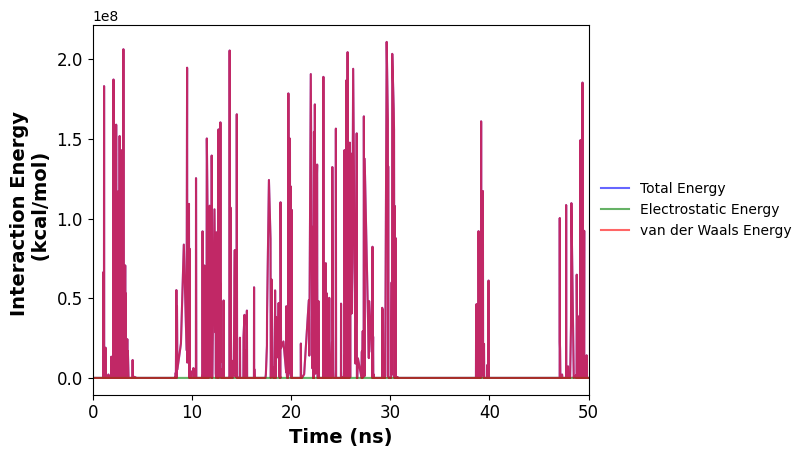

In [22]:
Output_name = 'Interaction_energy' #@param {type:"string"}

pt_topology = traj_load.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+) & !(:LIG)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]
mask = "LIE :LIG @" + str(first_atom+1) + "-" + str(last_atom+1)

lie = pt.analysis.energy_analysis.lie(traj_load, mask=mask, options='cutvdw 12.0 cutelec 12.0 diel 2.0', dtype='dict')

lie_elec = lie['LIE[EELEC]']
lie_vdw = lie['LIE[EVDW]']
lie_total = lie_elec + lie_vdw
Write_the_trajectory = traj_save_freq
time = len(lie_total)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

def filter_outliers(data):
    """Return a mask of booleans to filter out outliers."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data >= lower_bound) & (data <= upper_bound)

# Create masks for non-outliers
mask_total = filter_outliers(lie_total)
mask_elec = filter_outliers(lie_elec)
mask_vdw = filter_outliers(lie_vdw)

# Filter values based on the mask
filtered_time_total = time_array[mask_total]
filtered_lie_total = lie_total[mask_total]

filtered_time_elec = time_array[mask_elec]
filtered_lie_elec = lie_elec[mask_elec]

filtered_time_vdw = time_array[mask_vdw]
filtered_lie_vdw = lie_vdw[mask_vdw]

lie_total_mean = mean(filtered_lie_total)
lie_total_stdev = stdev(filtered_lie_total)
print("Interaction Energy Average = " + str("{:.2f}".format(lie_total_mean)) + " \u00B1 " + str("{:.2f}".format(lie_total_stdev)) + " kcal/mol")

# Plotting:
plt.plot(filtered_time_total, filtered_lie_total, alpha=0.6, color='blue', linewidth=1.5, label="Total Energy")
plt.plot(filtered_time_elec, filtered_lie_elec, alpha=0.6, color='green', linewidth=1.5, label="Electrostatic Energy")
plt.plot(filtered_time_vdw, filtered_lie_vdw, alpha=0.6, color='red', linewidth=1.5, label="van der Waals Energy")

plt.xlim(0, simulation_ns)
# plt.ylim(-50, 0)

plt.xlabel("Time (ns)", fontsize=14, fontweight='bold')
plt.ylabel('Interaction Energy \n (kcal/mol)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

lie_eelec = pd.DataFrame(lie['LIE[EELEC]'])
lie_eelec.to_csv(os.path.join(workDir, Output_name + "_eelec.csv"))
lie_evdw = pd.DataFrame(lie['LIE[EVDW]'])
lie_evdw.to_csv(os.path.join(workDir, Output_name + "_evdw.csv"))

<>:17: SyntaxWarning: invalid escape sequence '\A'
<>:17: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-1373069914.py:17: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')


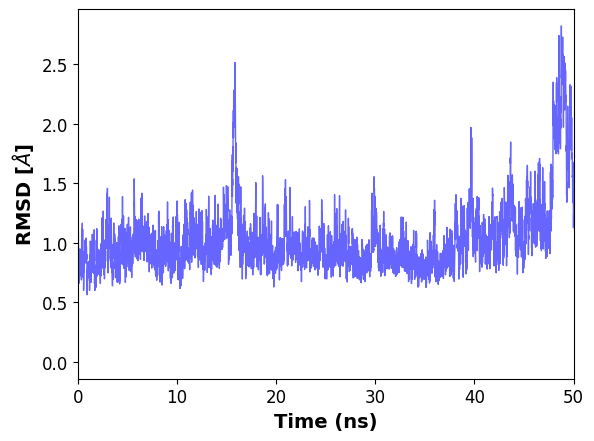

In [23]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:**
Output_name = 'rmsd_ca' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipython-input-676765789.py:14: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')


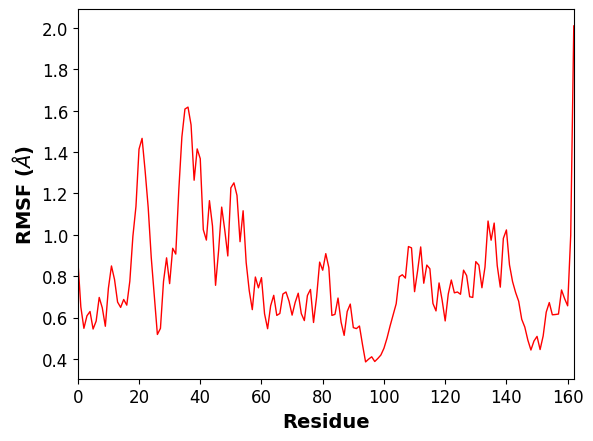

In [24]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [25]:
!jupyter nbconvert --to notebook --ClearOutputPreprocessor.enabled=True --inplace your_file.ipynb


[NbConvertApp] WARNING | pattern 'your_file.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    E